In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Rental Bike Study by cpu_in_flames

Links to our dataset, named **Rental bike demands on hourly and daily basis**:
https://www.kaggle.com/shelvigarg/rental-bike-demands-on-hourly-and-daily-basis?select=hour.csv

Second dataset, named  **2011-capitalbikeshare-tripdata.zip**:
https://s3.amazonaws.com/capitalbikeshare-data/index.html

Third dataset, named **2012-capitalbikeshare-tripdata.zip** :https://s3.amazonaws.com/capitalbikeshare-data/index.html

Importing our 
libraries :

In [ ]:
import matplotlib.pyplot as plt
import missingno as msn
import numpy as np
import pandas as pd
import seaborn as sns

#Data Set **Rental bike demands on hourly and daily basis** Information and Description:

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

##Attribute Information:

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index 
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit:
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [ ]:
df_hour = pd.read_csv("/content/drive/Shareddrives/BigData_project/data/hour.csv")

In [ ]:
df_day = pd.read_csv("/content/drive/Shareddrives/BigData_project/data/day.csv")

##Checking value integrity

We decided to observe our attributes types, as we can see from the list all attributes respect what we expected.

In [ ]:
df_hour.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
datestamp     datetime64[ns]
dtype: object

In order to do some useful hour aggregation we decided to transform the `dtday` attribute in *datetime* format, adding to the date informations hours of the `hr` attribute and creating a new features that is called `datestamp`.

In [ ]:
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'])
df_hour["datestamp"] = list(map(lambda x, y: x.replace(hour=y), df_hour["dteday"], df_hour["hr"]))

Now we verify if `cnt` is calculated as (`registered` + `casual`), let's check if this is true for all the rows for both our hourly and day dataset.

In [ ]:
cnt_hour = df_hour["cnt"] == pd.Series(map(lambda x, y: x + y, df_hour["casual"], df_hour["registered"]))
cnt_hour.all()

True

In [ ]:
cnt_day = df_day["cnt"] == pd.Series(map(lambda x, y: x + y, df_day["casual"], df_day["registered"]))
cnt_day.all()

True

As we can see there are not mistakes in both datasets.

##Equality hourly and day dataset

In order to check if our two datasets are equal we need to try to calculate day values in the day.csv starting with the hourly.csv values, so we need a group by date of our hourly dataset and aggregate features accordingly.

In [ ]:
attributes_mean = ["dteday", "weathersit", "temp", "atemp", "hum", "windspeed"]
attribute_sum = ["dteday", "casual", "registered", "cnt"]

We have splitted columns that need to be summed and those that need the mean.

In [ ]:
df_hour_groupby_sum = df_hour[attribute_sum].groupby('dteday').sum()

df_hour_groupby_mean = df_hour[attributes_mean].groupby('dteday').mean()

Since `weathersit` feature is an integer number we need to round it to its closest integer.

In [ ]:
df_hour_groupby_mean["weathersit"] = list(map(lambda x: round(x), df_hour_groupby_mean["weathersit"]))

The remaining features are rounded to 3 number after the comma and added in a new dataframe in order to easily check its equality.

In [ ]:
df = pd.DataFrame()
df["weathersit"] = pd.Series(map(lambda x, y: x - y, df_hour_groupby_mean["weathersit"], df_day["weathersit"]))
df["temp"] = pd.Series(map(lambda x, y: round(x, 3) - round(y, 3), df_hour_groupby_mean["temp"], df_day["temp"]))
df["atemp"] = pd.Series(map(lambda x, y: round(x, 3) - round(y, 3), df_hour_groupby_mean["atemp"], df_day["atemp"]))
df["hum"] = pd.Series(map(lambda x, y: round(x, 3) - round(y, 3), df_hour_groupby_mean["hum"], df_day["hum"]))
df["windspeed"] = pd.Series(map(lambda x, y: round(x, 3) - round(y, 3), df_hour_groupby_mean["windspeed"], df_day["windspeed"]))
df["casual"] = pd.Series(map(lambda x, y: x - y, df_hour_groupby_sum["casual"], df_day["casual"]))
df["registered"] = pd.Series(map(lambda x, y: x - y, df_hour_groupby_sum["registered"], df_day["registered"]))
df["cnt"] = pd.Series(map(lambda x, y: x - y, df_hour_groupby_sum["cnt"], df_day["cnt"]))
df.value_counts()

weathersit  temp    atemp  hum     windspeed  casual  registered  cnt
 0           0.000  0.0     0.000  0.0        0       0           0      670
             0.001  0.0     0.000  0.0        0       0           0       21
             0.000  0.0     0.001  0.0        0       0           0       14
            -0.001  0.0     0.000  0.0        0       0           0       11
             0.000  0.0    -0.001  0.0        0       0           0        9
-1           0.000  0.0     0.000  0.0        0       0           0        2
 0           0.001  0.0     0.001  0.0        0       0           0        1
                           -0.001  0.0        0       0           0        1
                            0.000  0.0        0       0           0        1
            -0.001  0.0    -0.001  0.0        0       0           0        1
dtype: int64

We have subtracted the values generated by our group by in the hour dataset to those in the day dataset. 

As we can see from the table above we have **almost the same values** for all the attributes with a variation of 0.001 due to the round operation. As the table suggest us, we can assume that both tables have the same values.

However if we look closely at weathersit column  we can found two "-1" values, why?

In [ ]:
temp = df_hour[["dteday", "weathersit"]].groupby('dteday').mean()

print(temp.loc['2011-04-16'])
print(temp.loc['2012-02-11'])

weathersit    2.5
Name: 2011-04-16 00:00:00, dtype: float64
weathersit    2.5
Name: 2012-02-11 00:00:00, dtype: float64


We have manually extracted those two istances from our dataset and we find out that both have a mean value of 2.5. In our mean it was  rounded down to 2 while in the day is rounded up to 3. 
Those two -1 ends up from 2 - 3.



#Data  Observation and Analysis of `hour.csv`

First we decide,given the equality of the two datasets, to analyze hour.csv from the point of view of understanding how the dataset is divided, how the values ​​of the variables are distributed, the co-relationship between them and if there are Missing values.


In [ ]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datestamp
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011-01-01 00:00:00
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011-01-01 01:00:00
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011-01-01 02:00:00
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011-01-01 03:00:00
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011-01-01 04:00:00


In [ ]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

In [ ]:
df_hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


These are the counts of unique values for each column.

In [ ]:
uni = {}
for col in df_hour:
	x = df_hour[col].unique()
	uni[col] = (len(x))
print(pd.Series(uni))

instant       17379
dteday          731
season            4
yr                2
mnth             12
hr               24
holiday           2
weekday           7
workingday        2
weathersit        4
temp             50
atemp            65
hum              89
windspeed        30
casual          322
registered      776
cnt             869
datestamp     17379
dtype: int64


So in conclusion our dataset is composed by **17 features**, with **1739 records**. We didn't expected this number because:

In [ ]:
(365 + 366) * 24

17544

If we add number of days for our two years (365 + 366) and * 24(hour per day) we must have 17544 features. But instead :

In [ ]:
17544 - 17379

165

Seems like we have 165 missing hours in our two years, we will check it in a dedicated section

The `instant` column at first look appears to be just a consecutive index in the range `1…len(df)+1`, so we checked if it actually is. Since it was exactly consecutive, we deleted it and used the standard pandas index `0…len(df)`.

In [ ]:
counter = 0
for row in df_hour["instant"]:
	if counter == row - 1:
		counter += 1
	else:
		print("oops")

# Feature Distribution

For the feature distribution we decided to plot the one that were more interesting to analyze starting from the simple Histogram, afetr that we do some lineplot and boxplot.


##Histogram

First of all we observe that we are analizing a space-time of 2 years so we decide to analyze if we have value for all the 730 days.
Of course we have a lot more of the 730 records, so we can rest assured that all days are covered.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


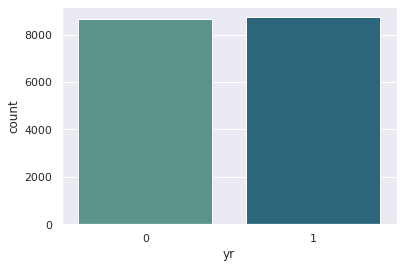

In [ ]:
sns.set()
sns.countplot(df_hour['yr'],palette="crest")

In [ ]:
df_hour['yr'].value_counts().sort_index()

0    8645
1    8734
Name: yr, dtype: int64

After that we analyze the distribution of the temporal features, `month, hour and weekday`.

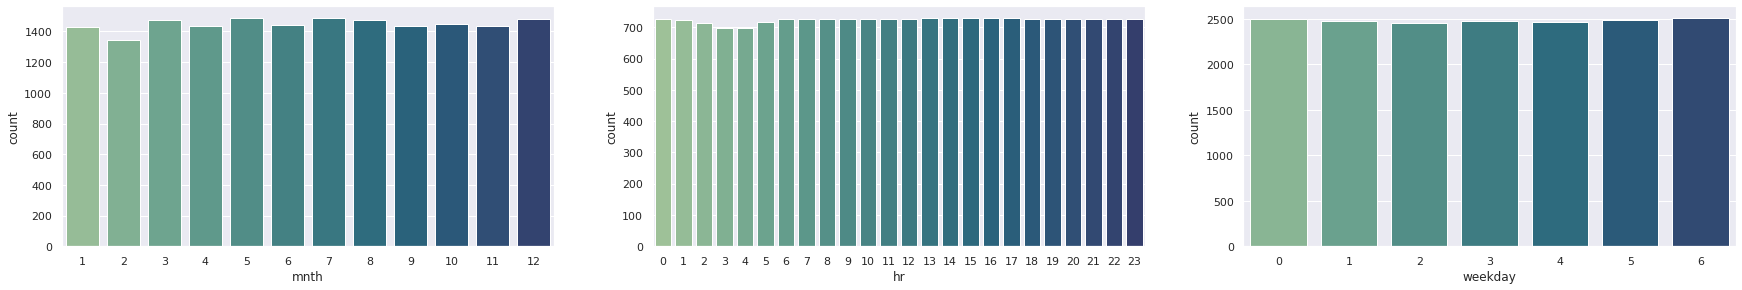

In [ ]:
sns.set()
fig = plt.subplots(figsize=(30, 15))
fig_dims =(3,3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.countplot(x=('mnth'), data=df_hour,palette="crest")

ax = plt.subplot2grid(fig_dims, (0, 1))
sns.countplot(x=('hr'), data=df_hour,palette="crest")

ax = plt.subplot2grid(fig_dims, (0, 2))
sns.countplot(x=('weekday'), data=df_hour,palette="crest")

The first visualization is about the counting of the **month distribution** into the dataset. If we observe also the single values like we did afeter we could see that not all the month have the same distribution. We think that this is normal because not all the month has the same number of days.

In [ ]:
df_hour['mnth'].value_counts().sort_index()

1     1429
2     1341
3     1473
4     1437
5     1488
6     1440
7     1488
8     1475
9     1437
10    1451
11    1437
12    1483
Name: mnth, dtype: int64

The second visualization is about the **hour distribution**. Observing the single values we notice that there are hours that don't cover all the days. We have, instead of 730 values, calculeted summing the 365+365 days discovered from the fact that we are analyzing 2 years, days that have less hours, like we analize before  this part. So this is important to fix, because we don't have all the value that could help us during the modeling part. The goal is to have for all the 24 hours, the same number of the values,730,and set to 0 the number of users, casual and registered,for that hours.Of course we can notice that expecially the night hours has this kind of missing values.  So we decide to replace the values in the part of the Missing value. 



In [ ]:
df_hour['hr'].value_counts().sort_index()

0     726
1     724
2     715
3     697
4     697
5     717
6     725
7     727
8     727
9     727
10    727
11    727
12    728
13    729
14    729
15    729
16    730
17    730
18    728
19    728
20    728
21    728
22    728
23    728
Name: hr, dtype: int64

The last distribution is about the `weekday` and also in this case we have the same problem of the hour part, so we think that fixing that part we could adjust also the distribution of that day that don't have the exact values of counting, in this case this is 2512.

In [ ]:
df_hour['weekday'].value_counts().sort_index()

0    2502
1    2479
2    2453
3    2475
4    2471
5    2487
6    2512
Name: weekday, dtype: int64

After the temporal analysis, we decide to analyze the variable `weathersit`, that is representative of the weather when the service was used and we think is crucial for our analysis because from her depends all the bike rental peaks.

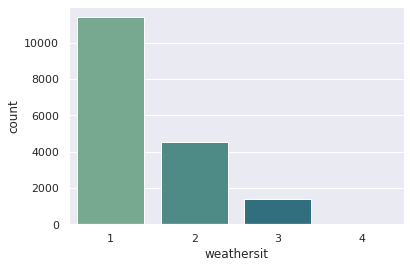

In [ ]:
sns.set()
sns.countplot(x=('weathersit'), data=df_hour,palette="crest")

In [ ]:
df_hour['weathersit'].value_counts().sort_index()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

Remebering his distribution we can observe that when the weather is not in the right conditions to be able to rent bikes, there are very few records for example when there are heavy rain or thunderstorm. Instead when there is a good wheter there are a lot of records rappresenting that most of the people rents bike.


|   Weatersit   index 	|                                     Rappresentation                                     	|
|:-------------------:	|:---------------------------------------------------------------------------------------:	|
|          1          	|                     Clear, Few clouds, Partly cloudy, Partly cloudy                     	|
|          2          	|               Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist              	|
|          3          	| Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 	|
|          4          	|                Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog               	|





##Lineplot

For this parte we first decide to analyze the **cnt** variable. This is going to be the sum of the casual and registered variables. So first we do a check and then we plot it.

In [ ]:
cnt = df_hour["cnt"] == pd.Series(map(lambda x, y: x + y, df_hour["casual"], df_hour["registered"]))
cnt.all()

True

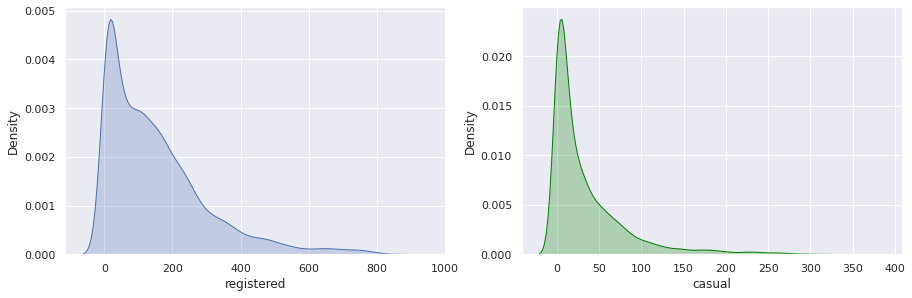

In [ ]:
sns.set()
fig = plt.subplots(figsize=(15, 10),sharey='all')
fig_dims =(2,2)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.kdeplot(df_hour['registered'], fill=True,palette="crest", linewidth=1)

ax = plt.subplot2grid(fig_dims, (0, 1))
sns.kdeplot(df_hour['casual'],fill=True, color ='green', linewidth=1)


Like we can see the number of `casual` user is not so much, but the density is highter than the `registered` ones. But the registered user are a lot more than the other one, like we can expect in normal life. If you are registered to a service, of course is normal to use it more than a tourist for example.

At the end we decide to see the distribution of the **weather forecast** variables.

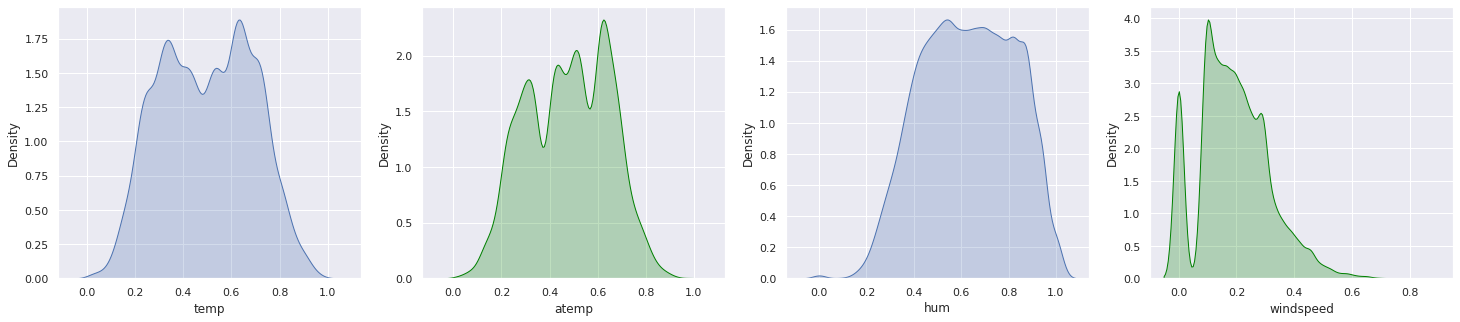

In [ ]:
fig = plt.subplots(figsize=(25, 5))
sns.set()

plt.subplot(1, 4, 1)
sns.kdeplot(df_hour['temp'], fill=True)
plt.subplot(1, 4, 2)
sns.kdeplot(df_hour['atemp'], fill=True, color='green')
plt.subplot(1, 4, 3)
sns.kdeplot(df_hour['hum'], fill=True)
plt.subplot(1, 4, 4)
sns.kdeplot(df_hour['windspeed'], fill=True, color='green')
plt.show()

- Like we remeber the `temp` features is the normalized **temperature** in Celsius. The values are derived via (t-tmin)/(tmax-tmin). For example with tmin=-8, t_max=+39 and t=10 we have the value 0.6. So like we can see the distribution is quite costant and we have peacks nearby the 0.3 and 0.7 values.

- Instead the `atemp` features is the normalized **feeling temperature** in Celsius and the values are derived via (t-tmin)/(tmax-tmin). For example with  tmin=-16, t_max=+50 and t = 19 we have 0.8. So any in this case we have a very dense distibution with almost all the value.

- For the `hum` ,of course the humidity value, features we also have normalized value divided to 100. For example if we have 72% of hum we have 0.72. So looking at the distribution we have some strange value that are derived from the fact that in some hour ther's no humidity or this is similar to 0 , for example if we have 9% of hum, that is a value that depends of the weather forecast in summer for example, this is 0.09 that is registered similar to 0, but is something normal in real-life. On the countrary we can say that for the hightst value in hum , this coud happen in winter or when ther's snow or rainy days.

- At the end we look at the `windspeed` distribution, also in this case the values are normalized, but in this case are divided by 67 that is the **maximum speed registered**. So that justfy the fact that there are a lot of small values nearby 0. That is because all the values < 10 are normalized like 0... explecially if is not a really ventilated city, this explain why there is a lot of small value.



##Double LinePlot

We decide to plot something more interesting to analyize ,or rhater something that is more constructive to better understood how are values are distributed. So we decide to do some line plot for analyze how much ,looking at the single line for a **single year**, the **weekday trend**,the **hour** and the **month** ,both for `registered` and `casual` users goese.

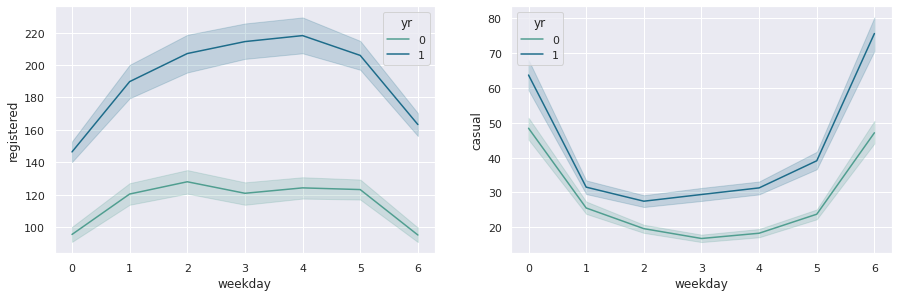

In [ ]:
sns.set()
fig = plt.subplots(figsize=(15, 10))
fig_dims =(2,2)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.lineplot(data=df_hour, x='weekday', y="registered", hue='yr',palette="crest")

ax = plt.subplot2grid(fig_dims, (0, 1))
sns.lineplot(data=df_hour, x='weekday', y="casual", hue='yr',palette="crest")


We can observe that of course for the year 0 that corrispond to 2011 there are less users , both casual and registered, and this is normal. 

- If we look at the single value, for the `registered` users, is more common to use a bike into the weekdays furthermore the weekend, 0 reppresent sunday and 6 saturday, so we can see that from monday to friday (1 to 5) the number of users is stable in both the years,also considering the fact that for year 1 or 2012 registered users are duplicated.

- Instead if we look at the point of view of the `casual` users, the situation is completely the opposite, at the end of the week there are a lot of users, instead in the weekday, the users are more less and if you observe monday , the 2 years has almost the same value of casual users.



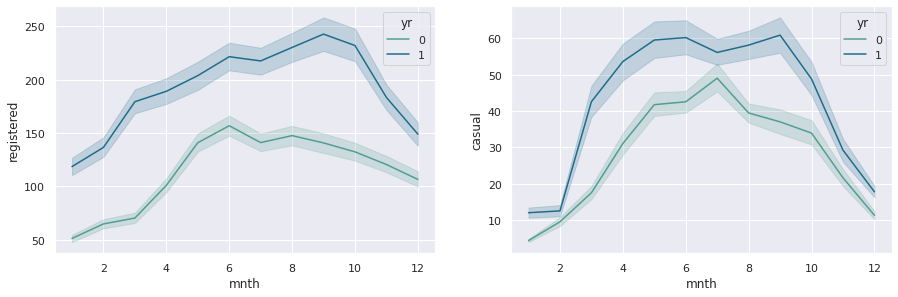

In [ ]:
sns.set()
fig = plt.subplots(figsize=(15, 10))
fig_dims =(2,2)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.lineplot(data=df_hour, x='mnth', y="registered", hue='yr',palette="crest")

ax = plt.subplot2grid(fig_dims, (0, 1))
sns.lineplot(data=df_hour, x='mnth', y="casual", hue='yr',palette="crest")



For this two plot we can say that for the registered and casual users, the month trend is similar in both the year.This is due to the fact that in the summer month there are a lot of more users as many of them are definitely tourists, for that we have peaks on that month for casual users. Instead for registered user, the trend is more linear during the year.

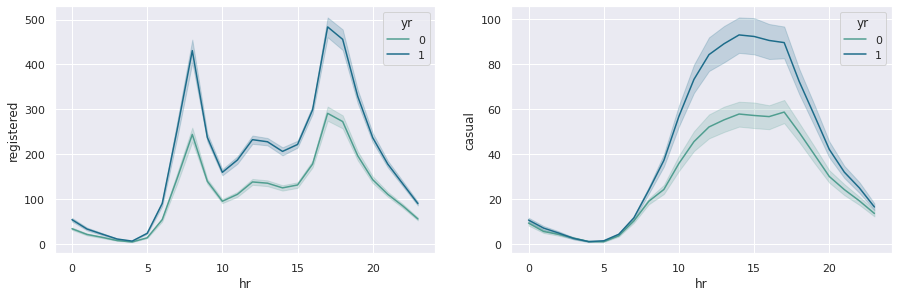

In [ ]:
sns.set()
fig = plt.subplots(figsize=(15, 10))
fig_dims =(2,2)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.lineplot(data=df_hour, x='hr', y="registered", hue='yr',palette="crest")

ax = plt.subplot2grid(fig_dims, (0, 1))
sns.lineplot(data=df_hour, x='hr', y="casual", hue='yr',palette="crest")

This final two plot instead rappresents the hour distribution of the users.We can observe that the situation for the registered and casual users is completely different:

- We can say that `registered` users use a lot the service in the morning,form 6 to 10, for example for going to work or school, and at 16-19 , that is the hour to come back home. This is a very important observation because we can draw from it in conclusion that most of the registered users are person that use the service for a specific purpose.

- Instead the `casual` users use a lot the bike during the day from 10 to 19 a meaning of the fact that most of them use it for moving around the city,like torurists or someone that don't use the service for a specific purpose like the registered onece.



##Boxplot

[]

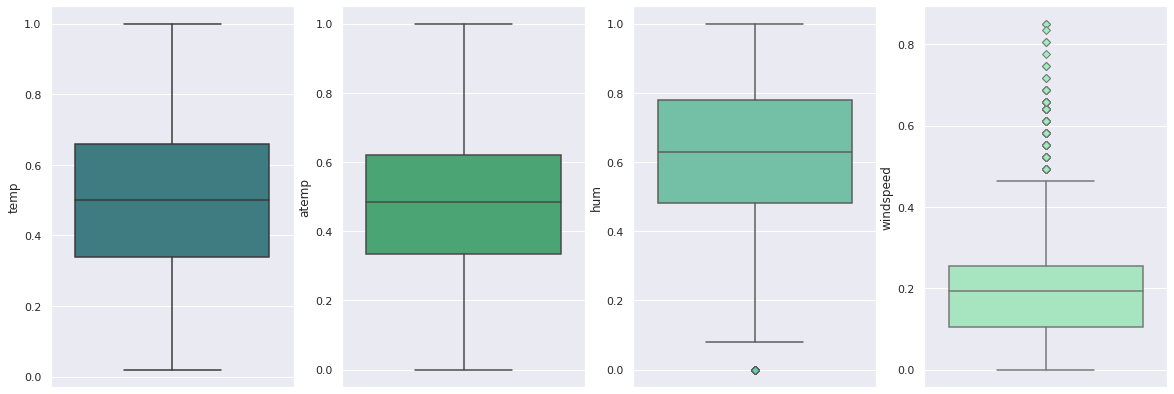

In [ ]:
sns.set()
green_diamond = dict(markerfacecolor='#9DEFBE', marker='D')
blue_diamond = dict(markerfacecolor='mediumaquamarine', marker='D')
fig = plt.subplots(figsize=(20, 7))

plt.subplot(1, 4, 1)
sns.boxplot(data = df_hour,y='temp',flierprops=blue_diamond,palette ='crest')

plt.subplot(1, 4, 2)
sns.boxplot(data = df_hour,y='atemp',flierprops=green_diamond,color = 'mediumseagreen')

plt.subplot(1, 4, 3)
sns.boxplot(data = df_hour,y='hum',flierprops=blue_diamond,color ='mediumaquamarine')

plt.subplot(1, 4, 4)
sns.boxplot(data = df_hour,y='windspeed',flierprops=green_diamond,color ='#9DEFBE')

sns.color_palette("crest", as_cmap=True)
plt.plot()

At the end we decide to plot 4 boxplot of the most rappresentative lineplot of our dataset.

- We can say that for `temp` and `atemp` ther's not so much problem, no outliers and we observe it also in the distribution that is quite standard and not so much complicated to analyze.

- Instead if we observe the `hum` features ,we have some outliers at 0 representig that days that are not so much humid and that with the normalization of small values, less than 10, they give a value very close to 0 .

- Finally the `windspeed` boxplot. In this case the outliers are value after 0.5 so for example from the 34 km/h windspeed to the 67 km/h there are all this kind of outliers that are single registration for example, during the 2 years, that rappresent some important information for that day and for that we decided to keep them and don't treat it.



# Creation of an interface

At this point we realized that, when we tackle the next objectives for the remainder of the project, we will want to keep all the various preprocessing steps we're doing consistent, centralized in a single spot and easily accessible. With this in mind we have created a python module that we will import and use from this point forwards. This has a few benefits:

1. less error prone due to no need to duplicate code;
2. any improvements we should want to do to the preprocessing, or any fix for mistakes or bugs, are automatically deployed to all notebooks.

The page containing the preprocessing steps is on a [public GitHub repo](https://github.com/gatto/ds-bigdata/blob/main/src/extract.py) and, although it only does what we've talked about, we'd like to quickly show it.

The following block is how we import the module and start using it.

In [ ]:
!pip install -U git+https://github.com/gatto/ds-bigdata.git
from extractbda import Bikes
d = Bikes()
d.df.info()

  Cloning https://github.com/gatto/ds-bigdata.git to /tmp/pip-req-build-5pq6obmi
  Running command git clone -q https://github.com/gatto/ds-bigdata.git /tmp/pip-req-build-5pq6obmi
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for extractbda: filename=extractbda-0.3-py3-none-any.whl size=431024 sha256=0c655fb6de3c3d7527d83b221674c34f466dea9709827a8a18d145f1c148ea03
  Stored in directory: /tmp/pip-ephem-wheel-cache-81pkglyq/wheels/65/87/46/3bd8b72398b13604298d6babe6e2c27b9704ca35bd2ecaae98
Successfully built extractbda
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17455 entries, 0 to 17543
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   dteday          17455 non-null  datetime64[ns]
 1   season          17455 non-null  float64       
 2   yr              17455 non-null  float64       
 3   mnth   

# Correlation Matrix



In [ ]:
!pip install -U git+https://github.com/gatto/ds-bigdata.git
from extractbda import Bikes

  Cloning https://github.com/gatto/ds-bigdata.git to /tmp/pip-req-build-lu5qp3yi
  Running command git clone -q https://github.com/gatto/ds-bigdata.git /tmp/pip-req-build-lu5qp3yi
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


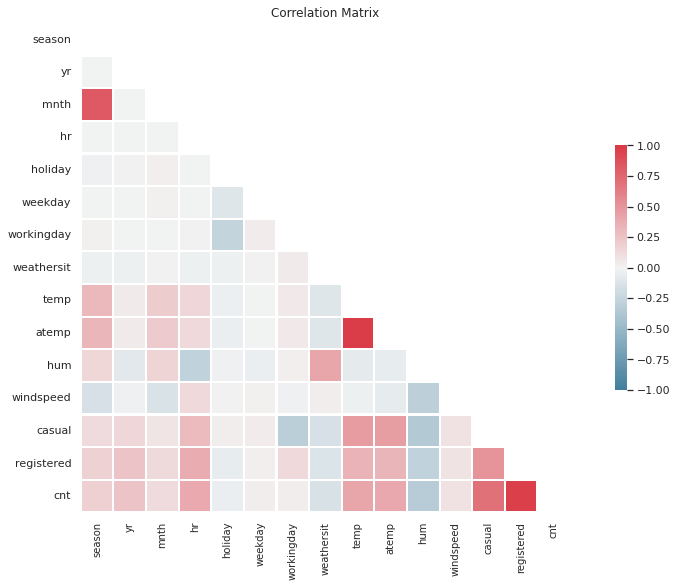

In [ ]:
d = Bikes()
sns.set_theme(style="white")

corr = d.df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(16, 9))
cmap = sns.diverging_palette(230, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1, square=True, linewidths=1.1, cbar_kws={"shrink": 0.5},)
plt.title("Correlation Matrix")
plt.xticks(fontsize=10)
plt.show()

Looking at the coorelation matrix we can observe how the features are correleted between them. First of all we can observe that `mnth` and `season` features are strictly coorelated and that is normal. Also `temp `and `atemp` are correleted positively and we observe that are a good things. At the end we can say that also `cnt`,`casual` and `registered` are related and that is a confirm of what we explore in the previous part.

From the plot above we can identify two blocks of correlation, the first one tells us that season, year, month and hour are correlated to casual, registered and cnt and obviously to temp and atemp.

The second one tells us that the temperature and feeling temperature is correlated to cnt, registered and casual. 

# Missing Values Imputation



Let's look at the missing value, usigin the library Missingno:

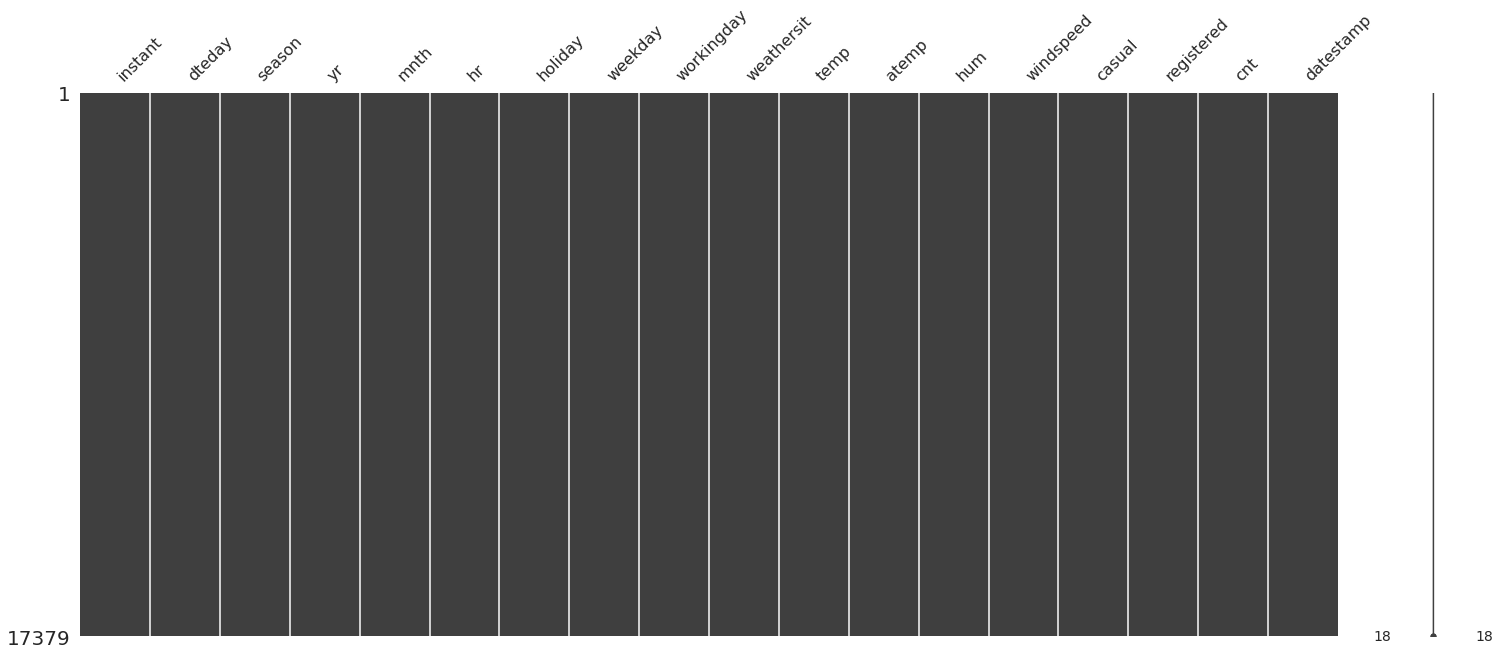

In [ ]:
msn.matrix(df_hour)

In this dataset there apparently are no missing values. However, we noticed that the number of instances doesn't match the total number of hours in two years. 

We found out there are actually some ***missing rows*** and missing values start to appear when we add a new feature containing all the hour stamp from 1th Jan 2011 to 31th Dec 2012

## Missing Record Resolution

In [ ]:
df = Bikes()
df_tofill = df.df_full

All the missing values are added in a new dataframe 

In [ ]:
df_missing = df_tofill[~df_tofill['cnt'].notnull()]

We have observed that there are two kinds of missing records:

1.   Few random missing hours throughout the day (mostly during night)
2.   Some days with many consecutive missing hours

We assumed that in the first case the rental bikes system was not used by none, for this reason we decided to manually add this information that was not included in the original dataset, adding a new row with  `casual `,  `registered ` and  `cnt ` equal to 0, replacing the meteorological information with the previous hours.

In the second case we assumed that the rental bikes system was unavailable for maintenance or for some natural disaster that stopped users to use the system. Since this second cases is rare we decided to exclude in our analysis these hours.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Frequency')

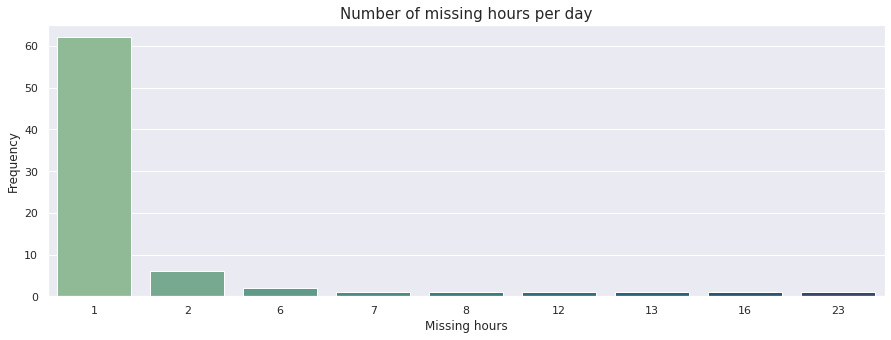

In [ ]:
sns.set()
#dataframe with only missing values rows
mask = ~df_tofill['cnt'].notnull()
df_missing = df_tofill.loc[mask, :].copy()

#add a new column composed by only the date for the group by to check how many missing hours per day
df_missing["date_full"] = df_missing["datestamp_full"].dt.date

head = df_missing.groupby(["date_full"]).size().value_counts()
plt.figure(figsize=(15,5))
sns.barplot(head.index,head.values,palette="crest")

plt.title('Number of missing hours per day',fontsize = 15)
plt.xlabel('Missing hours')
plt.ylabel('Frequency')


In this plot we have grouped by day and then counted how many days have missing hours. We can observe that only few days have more than 2 missing hours, for this reason we decided to use a thresholds equal to 3 consecutive missing hours to distinguish our first case from the second one.

In order to do what we said we created a boolean list that flag those rows that represent blocks of consecutive missing hours

In [ ]:
date = df_missing["datestamp_full"]
hour = pd.Timedelta('1h')
in_block = ((date - date.shift(-1)).abs() == hour) | (date.diff() == hour)

for consecutive in zip(in_block, df_missing["datestamp_full"]):
  print(consecutive)

(False, Timestamp('2011-01-02 05:00:00'))
(True, Timestamp('2011-01-03 02:00:00'))
(True, Timestamp('2011-01-03 03:00:00'))
(False, Timestamp('2011-01-04 03:00:00'))
(False, Timestamp('2011-01-05 03:00:00'))
(False, Timestamp('2011-01-06 03:00:00'))
(False, Timestamp('2011-01-07 03:00:00'))
(True, Timestamp('2011-01-11 03:00:00'))
(True, Timestamp('2011-01-11 04:00:00'))
(True, Timestamp('2011-01-12 03:00:00'))
(True, Timestamp('2011-01-12 04:00:00'))
(False, Timestamp('2011-01-14 04:00:00'))
(True, Timestamp('2011-01-18 00:00:00'))
(True, Timestamp('2011-01-18 01:00:00'))
(True, Timestamp('2011-01-18 02:00:00'))
(True, Timestamp('2011-01-18 03:00:00'))
(True, Timestamp('2011-01-18 04:00:00'))
(True, Timestamp('2011-01-18 05:00:00'))
(True, Timestamp('2011-01-18 06:00:00'))
(True, Timestamp('2011-01-18 07:00:00'))
(True, Timestamp('2011-01-18 08:00:00'))
(True, Timestamp('2011-01-18 09:00:00'))
(True, Timestamp('2011-01-18 10:00:00'))
(True, Timestamp('2011-01-18 11:00:00'))
(False, Ti

We added an id for each group of consecutive rows. 

In [ ]:
filt = df_missing.loc[in_block]
breaks = filt['datestamp_full'].diff() != hour
groups = breaks.cumsum()
groups

50        1
51        1
243       2
244       2
267       3
         ..
16040    11
16041    11
16042    11
16043    11
16044    11
Name: datestamp_full, Length: 101, dtype: int64

Then we added this new feature to our dataframe with only missing values

In [ ]:
df_missing['groups'] = groups
df_missing

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datestamp_full,date_full,groups
29,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-02 05:00:00,2011-01-02,NaN
50,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-03 02:00:00,2011-01-03,1.0
51,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-03 03:00:00,2011-01-03,1.0
75,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-04 03:00:00,2011-01-04,NaN
99,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-05 03:00:00,2011-01-05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16044,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-30 12:00:00,2012-10-30,11.0
16251,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-08 03:00:00,2012-11-08,NaN
16755,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-29 03:00:00,2012-11-29,NaN
17356,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-12-24 04:00:00,2012-12-24,NaN


As last thing we counted how many missing hours were consecutive and filtered those greather than 3, as we specified above.

In [ ]:
groups_count = df_missing.groupby(['groups'], as_index=False).size()
df_missing_groups = pd.merge(df_missing, groups_count, on=["groups", "groups"])
dates_to_discard = df_missing_groups[df_missing_groups["size"] > 3]
list_dates_to_discard = list(dates_to_discard["datestamp_full"])

We just removed the list of hours generated in the previous step to our full hourly dataset.

In [ ]:
df_tofill = df_tofill.loc[(~df_tofill["datestamp_full"].isin(list_dates_to_discard)), :].copy()
df_tofill

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datestamp_full
0,2011-01-01,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0,2011-01-01 00:00:00
1,2011-01-01,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0,2011-01-01 01:00:00
2,2011-01-01,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,5.0,27.0,32.0,2011-01-01 02:00:00
3,2011-01-01,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0,2011-01-01 03:00:00
4,2011-01-01,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0,2011-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2012-12-31,1.0,1.0,12.0,19.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,11.0,108.0,119.0,2012-12-31 19:00:00
17540,2012-12-31,1.0,1.0,12.0,20.0,0.0,1.0,1.0,2.0,0.26,0.2576,0.60,0.1642,8.0,81.0,89.0,2012-12-31 20:00:00
17541,2012-12-31,1.0,1.0,12.0,21.0,0.0,1.0,1.0,1.0,0.26,0.2576,0.60,0.1642,7.0,83.0,90.0,2012-12-31 21:00:00
17542,2012-12-31,1.0,1.0,12.0,22.0,0.0,1.0,1.0,1.0,0.26,0.2727,0.56,0.1343,13.0,48.0,61.0,2012-12-31 22:00:00


Once removed all the consecutive missing records greather than 3, we decided to fill all the remaining random missing records. We replaced their *casual*, *registered* and *cnt* with 0; the meteorological information with them in the previous hours.


In [ ]:
df_tofill[['casual', 'registered', 'cnt']].fillna(value=0, inplace = True)

df_tofill.ffill(inplace=True)
df_tofill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17455 entries, 0 to 17543
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   dteday          17455 non-null  datetime64[ns]
 1   season          17455 non-null  float64       
 2   yr              17455 non-null  float64       
 3   mnth            17455 non-null  float64       
 4   hr              17455 non-null  float64       
 5   holiday         17455 non-null  float64       
 6   weekday         17455 non-null  float64       
 7   workingday      17455 non-null  float64       
 8   weathersit      17455 non-null  float64       
 9   temp            17455 non-null  float64       
 10  atemp           17455 non-null  float64       
 11  hum             17455 non-null  float64       
 12  windspeed       17455 non-null  float64       
 13  casual          17455 non-null  float64       
 14  registered      17455 non-null  float64       
 15  cn

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,















# Geo-exploration 

In the next section we use geopandas in order to make a geographical exploration and analyze the behaviour of rental biker in different zone of Washington and neighborhood.

In [ ]:
!pip install pygeos
!pip install rtree
!pip install geopandas
!pip install geopy

     |████████████████████████████████| 2.1 MB 4.9 MB/s 
     |████████████████████████████████| 994 kB 5.2 MB/s 
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 34.4 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 


In [ ]:
import datetime
import geopandas as gpd
import geopy

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Load dataset
From the website https://www.capitalbikeshare.com/system-data it's possible to download the data collected by Capital Bikeshare,like we said at the start of this notebook, which is the source used to create **day.csv** and **hour.csv**.

Indeed this one collects the trip information at a smaller granularity wrt the dataset that we are working with: each rows correspond to a single trip with information about the start/end station, bike number, trip duration and customer typology.

The **day.csv** and **hour.csv** can be obtained grouping on day or hour and by counting the occurence of *Member*, *Casual* in the attribute `Member type`.

In [ ]:
#Dataset for the year 2011
df_11= pd.read_csv('/content/drive/Shareddrives/BigData_project/data/2011-capitalbikeshare-tripdata.csv')

#Datasets for the year 2012, didided by quorter, so we have :

df_q1= pd.read_csv('/content/drive/Shareddrives/BigData_project/data/2012Q1-capitalbikeshare-tripdata.csv')
#for January,February and March rilevation

df_q2= pd.read_csv('/content/drive/Shareddrives/BigData_project/data/2012Q2-capitalbikeshare-tripdata.csv')
#for April,May and June rilevation

df_q3= pd.read_csv('/content/drive/Shareddrives/BigData_project/data/2012Q3-capitalbikeshare-tripdata.csv')
#for July, August and September rilevation

df_q4= pd.read_csv('/content/drive/Shareddrives/BigData_project/data/2012Q4-capitalbikeshare-tripdata.csv')
#for October, November and December rilevation

In [ ]:
df_11.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,3548,2011-01-01 00:01:29,2011-01-01 01:00:37,31620,5th & F St NW,31620,5th & F St NW,W00247,Member
1,346,2011-01-01 00:02:46,2011-01-01 00:08:32,31105,14th & Harvard St NW,31101,14th & V St NW,W00675,Casual
2,562,2011-01-01 00:06:13,2011-01-01 00:15:36,31400,Georgia & New Hampshire Ave NW,31104,Adams Mill & Columbia Rd NW,W00357,Member
3,434,2011-01-01 00:09:21,2011-01-01 00:16:36,31111,10th & U St NW,31503,Florida Ave & R St NW,W00970,Member
4,233,2011-01-01 00:28:26,2011-01-01 00:32:19,31104,Adams Mill & Columbia Rd NW,31106,Calvert & Biltmore St NW,W00346,Casual


In [ ]:
df_d= pd.read_csv('/content/drive/Shareddrives/BigData_project/data/day.csv')

In [ ]:
df_d.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


##Date attribute transformation
Here we make some attribute trasformation that let we merge ‘day.csv’ with ‘df_11’ and ‘df_12’ the base subdataset referred to years 2011 and 2012.

- In day.csv: converting 'dteday' in datetime format.
- In df_11 and df_12: converting 'Start date' in datetime format removing the hour information.

So now the datasets can be merge on 'dteday'=='Start date'

In [ ]:
df_d['dteday']= pd.to_datetime(df_d['dteday'])

In [ ]:
def convert_startdate(df):
    df['Start date']= pd.to_datetime(df['Start date'])
    df['Start date'] = list(map(lambda x: x.replace(hour=0, minute=0, second=0), df['Start date']))

In [ ]:
convert_startdate(df_11)
convert_startdate(df_q1)
convert_startdate(df_q2)
convert_startdate(df_q3)
convert_startdate(df_q4)

In [ ]:
df_q4.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,611,2012-10-01,2012-10-01 00:12:17,31230,Metro Center / 12th & G St NW,31212,21st & M St NW,W00311,Member
1,612,2012-10-01,2012-10-01 00:13:05,31624,North Capitol St & F St NW,31251,12th & L St NW,W00137,Member
2,734,2012-10-01,2012-10-01 00:18:48,31234,20th & O St NW / Dupont South,31223,Convention Center / 7th & M St NW,W20125,Member
3,219,2012-10-01,2012-10-01 00:11:06,31106,Calvert & Biltmore St NW,31104,Adams Mill & Columbia Rd NW,W01451,Member
4,924,2012-10-01,2012-10-01 00:22:53,31109,7th & T St NW,31615,6th & H St NE,W00441,Member


In [ ]:
df_12= pd.concat([df_q1,df_q2,df_q3,df_q4])
df_12.reset_index(drop=True, inplace=True)
df_12

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,475,2012-01-01,2012-01-01 00:11:56,31245,7th & R St NW / Shaw Library,31109,7th & T St NW,W01412,Member
1,1162,2012-01-01,2012-01-01 00:29:28,31400,Georgia & New Hampshire Ave NW,31103,16th & Harvard St NW,W00524,Casual
2,1145,2012-01-01,2012-01-01 00:29:28,31400,Georgia & New Hampshire Ave NW,31103,16th & Harvard St NW,W00235,Member
3,485,2012-01-01,2012-01-01 00:23:46,31101,14th & V St NW,31602,Park Rd & Holmead Pl NW,W00864,Member
4,471,2012-01-01,2012-01-01 00:23:34,31102,11th & Kenyon St NW,31109,7th & T St NW,W00995,Member
...,...,...,...,...,...,...,...,...,...
2028906,8630,2012-12-31,2013-01-01 02:15:29,31619,Lincoln Park / 13th & East Capitol St NE,31619,Lincoln Park / 13th & East Capitol St NE,W00704,Casual
2028907,418,2012-12-31,2013-01-01 00:03:17,31101,14th & V St NW,31200,Massachusetts Ave & Dupont Circle NW,W00098,Member
2028908,384,2012-12-31,2013-01-01 00:03:00,31101,14th & V St NW,31200,Massachusetts Ave & Dupont Circle NW,W01398,Member
2028909,448,2012-12-31,2013-01-01 00:05:49,31613,Eastern Market Metro / Pennsylvania Ave & 7th ...,31607,14th & D St SE,W01301,Member


In [ ]:
del(df_q1)
del(df_q2)
del(df_q3)
del(df_q4)

## Comparing the measure (casual, registered, cnt)
In this section we compare the measure (casual, registere, cnt) of 'day.csv' with the one computed from the df_11 and df_12 to see if there is a corrispondece between them.

To compute the measure we define 2 function which count the occurrence of member and casual.

In [ ]:
def registered_count(grp):
    d= dict(zip(grp.value_counts().index, grp.value_counts()))
    try:
        return d['Member']
    except:
        return 0

In [ ]:
def casual_count(grp):
    d= dict(zip(grp.value_counts().index, grp.value_counts()))
    try:
        return d['Casual']
    except:
        return 0

### For 2011
We first show the measure for 'day.csv'

In [ ]:
meas_d=df_d[df_d['yr']==0][['casual','registered','cnt']]
meas_d

,casual,registered,cnt
0,331,654,985
1,131,670,801
2,120,1229,1349
3,108,1454,1562
4,82,1518,1600
...,...,...,...
360,103,1059,1162
361,255,2047,2302
362,254,2169,2423
363,491,2508,2999


Then we group by 'Start date' and aggregate counting the occurence of casual and registered

In [ ]:
meas_11=df_11.groupby('Start date').agg(casual=('Member type', lambda x: casual_count(x)),
                                          registered=('Member type', lambda x: registered_count(x)),
                                          cnt=('Member type', 'count'))
meas_11.reset_index(inplace=True)
meas_11.drop('Start date', axis=1, inplace=True)
meas_11

,casual,registered,cnt
0,330,629,959
1,130,651,781
2,120,1181,1301
3,107,1429,1536
4,82,1489,1571
...,...,...,...
360,103,1049,1152
361,255,2020,2275
362,254,2149,2403
363,491,2476,2967


In [ ]:
(meas_d['casual']==meas_11['casual']).value_counts()

True     190
False    175
Name: casual, dtype: int64

In [ ]:
(meas_d['registered']==meas_11['registered']).value_counts()

False    365
Name: registered, dtype: int64

As can be seen there are 190 out of 365 value of casual that perfectly match between the df_d and d_11, while registered never match.

This may be caused by a different preprocessing made on the dataset. In fact on the website there is a note to report some removed trip that probably haven't been removed from 'day.csv'

"This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of our “test” stations at our warehouses and any trips lasting less than 60 seconds (potentially false starts or users trying to re-dock a bike to ensure it's secure)."

In [ ]:
#there are also some Unknown member
df_11['Member type'].value_counts()

Member     979814
Casual     246949
Unknown         4
Name: Member type, dtype: int64

### For 2012

In [ ]:
meas_d=df_d[df_d['yr']==1][['casual','registered','cnt']].reset_index(drop=True)
meas_d

,casual,registered,cnt
0,686,1608,2294
1,244,1707,1951
2,89,2147,2236
3,95,2273,2368
4,140,3132,3272
...,...,...,...
361,247,1867,2114
362,644,2451,3095
363,159,1182,1341
364,364,1432,1796


In [ ]:
meas_11=df_12.groupby('Start date').agg(casual=('Member type', lambda x: casual_count(x)),
                                          registered=('Member type', lambda x: registered_count(x)),
                                          cnt=('Member type', 'count'))
meas_11.reset_index(inplace=True)
meas_11.drop('Start date', axis=1, inplace=True)
meas_11

,casual,registered,cnt
0,688,1572,2260
1,244,1693,1937
2,89,2130,2219
3,95,2262,2357
4,140,3111,3251
...,...,...,...
361,247,1849,2096
362,644,2424,3068
363,158,1170,1328
364,364,1416,1780


In [ ]:
(meas_d['casual']==meas_11['casual']).value_counts()

True     222
False    144
Name: casual, dtype: int64

In [ ]:
(meas_d['registered']==meas_11['registered']).value_counts()

False    366
Name: registered, dtype: int64

In [ ]:
#there are also some Unknown member
df_12['Member type'].value_counts()

Member     1656252
Casual      372642
Unknown         17
Name: Member type, dtype: int64

In [ ]:
df= pd.concat([df_11,df_12]).groupby(['Start station']).agg(casual=('Member type', lambda x: casual_count(x)),
                                          registered=('Member type', lambda x: registered_count(x)),
                                          cnt=('Member type', 'count'))
df.reset_index(inplace=True)

In [ ]:
df

,Start station,casual,registered,cnt
0,10th & E St NW,2140,4140,6280
1,10th & Monroe St NE,665,4758,5423
2,10th & U St NW,3681,34468,38149
3,10th St & Constitution Ave NW,17423,16259,33682
4,11th & F St NW,0,38,38
...,...,...,...,...
189,Wilson Blvd & Franklin Rd,579,2793,3372
190,Wilson Blvd & N Edgewood St,552,2173,2725
191,Wilson Blvd & N Quincy St,216,1615,1831
192,Wilson Blvd & N Uhle St,909,6330,7239


## Station location
In this section we extract the Capital Bikeshare station in order to show how they are disposed and how many trip start from that station using Geopandas.

- https://gist.github.com/since1968/e51c0f3d95e67bf49f74#file-bikestations-csv
- https://opendata.dc.gov/datasets/capital-bike-share-locations/explore

In the links above can be downloaded 2 dataset containing some useful information about Capital Bikeshare station such latitude and longitude that we want to retrieve (it is also possible to retirive them using a geocoder but this way is less reliable however we used it for 3 station that we cannot found in those datasets).

In [ ]:
df_s= pd.read_csv('/content/drive/Shareddrives/BigData_project/data/bikeStations.csv')
df_s1= pd.read_csv('/content/drive/Shareddrives/BigData_project/data/Capital_Bike_Share_Locations.csv')

In [ ]:
df_s

,id,name,terminalName,lastCommWithServer,lat,long,installed,locked,installDate,removalDate,temporary,public,nbBikes,nbEmptyDocks,latestUpdateTime
0,1,20th & Bell St,31000,1401797061989,38.856100,-77.051200,True,False,1316059200000,NaN,False,True,6,4,1401767305529
1,2,18th & Eads St.,31001,1401797182939,38.857250,-77.053320,True,False,1284989400000,NaN,False,True,9,2,1401797182549
2,3,20th & Crystal Dr,31002,1401797195562,38.856400,-77.049200,True,False,1284464580000,NaN,False,True,14,0,1401796712462
3,4,15th & Crystal Dr,31003,1401797127300,38.860170,-77.049593,True,False,1284464880000,NaN,False,True,8,2,1401797126538
4,5,Aurora Hills Community Ctr/18th & Hayes St,31004,1401797170204,38.857866,-77.059490,True,False,1284464880000,NaN,False,True,4,5,1401794911610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,324,Shirlington Transit Center / S Quincy & Randol...,31076,1401797114672,38.839912,-77.087083,True,False,1394637480000,NaN,False,True,12,2,1401795942005
312,325,Shady Grove Metro West,32045,1401797086905,39.119765,-77.166093,True,False,1397837820000,NaN,False,True,5,14,1401771990962
313,326,River Rd & Landy Ln,32046,1401797208100,38.964992,-77.103381,True,False,1396972380000,NaN,False,True,3,16,1401771991539
314,327,Rockville Metro West,32047,1401797157642,39.084379,-77.146866,True,False,1397847900000,NaN,False,True,6,12,1401772070593


We take all the unique station from df_11 and df_12 and we create a dataframe to contain them

In [ ]:
stat= dict(zip(df_11['Start station'],df_11['Start station number']))

In [ ]:
stat.update(dict(zip(df_12['Start station'],df_12['Start station number'])))

In [ ]:
stat

{'10th & E St NW': 31256,
 '10th & Monroe St NE': 31504,
 '10th & U St NW': 31111,
 '10th St & Constitution Ave NW': 31219,
 '11th & F St NW': 31262,
 '11th & H St NE': 31614,
 '11th & Kenyon St NW': 31102,
 '11th & M St NW': 31266,
 '12th & Army Navy Dr': 31008,
 '12th & L St NW': 31251,
 '12th & Newton St NE': 31501,
 '13th & D St NE': 31622,
 '13th & H St NE': 31611,
 '13th St & New York Ave NW': 31227,
 '14th & D St NW / Ronald Reagan Building': 31231,
 '14th & D St SE': 31607,
 '14th & G St NW': 31238,
 '14th & Harvard St NW': 31105,
 '14th & R St NW': 31202,
 '14th & Rhode Island Ave NW': 31203,
 '14th & V St NW': 31101,
 '14th St & New York Ave NW': 31216,
 '14th St & Spring Rd NW': 31401,
 '14th St Heights / 14th & Crittenden St NW': 31402,
 '15th & Crystal Dr': 31003,
 '15th & K St NW': 31254,
 '15th & N Scott St': 31031,
 '15th & P St NW': 31201,
 '15th St & Massachusetts Ave SE': 31626,
 '16th & Harvard St NW': 31103,
 '17th & Corcoran St NW': 31214,
 '17th & K St NW': 31213

In [ ]:
df_stat= pd.DataFrame.from_dict(stat, orient='index')
df_stat= df_stat.reset_index().rename(columns={'index':'station', 0:'number'})
df_stat

,station,number
0,5th & F St NW,31620
1,14th & Harvard St NW,31105
2,Georgia & New Hampshire Ave NW,31400
3,10th & U St NW,31111
4,Adams Mill & Columbia Rd NW,31104
...,...,...
189,King St & Patrick St,31044
190,Henry St & Pendleton St,31046
191,Arlington Blvd & N Queen St,31051
192,Barton St & 10th St N,31050


Now we merge the station dataset and the one from github togheter on ('station','number') to get 179 out of 194 station filled

In [ ]:
df_stat.merge(df_s, left_on=['station','number'], right_on=['name','terminalName'])

,station,number,id,name,terminalName,lastCommWithServer,lat,long,installed,locked,installDate,removalDate,temporary,public,nbBikes,nbEmptyDocks,latestUpdateTime
0,5th & F St NW,31620,82,5th & F St NW,31620,1401797206240,38.897222,-77.019347,True,False,1286492280000,NaN,False,True,11,20,1401797205667
1,14th & Harvard St NW,31105,19,14th & Harvard St NW,31105,1401797222991,38.926800,-77.032200,True,False,1284465540000,NaN,False,True,1,18,1401797221290
2,Georgia & New Hampshire Ave NW,31400,28,Georgia & New Hampshire Ave NW,31400,1401797229239,38.936043,-77.024649,True,False,1284465900000,NaN,False,True,0,12,1401797217530
3,10th & U St NW,31111,43,10th & U St NW,31111,1401797068783,38.917200,-77.025900,True,False,1285822380000,NaN,False,True,0,15,1401797067454
4,Adams Mill & Columbia Rd NW,31104,18,Adams Mill & Columbia Rd NW,31104,1401797260135,38.922925,-77.042581,True,False,1284465540000,NaN,False,True,0,15,1401795329013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,King St & Patrick St,31044,192,King St & Patrick St,31044,1401797052299,38.805317,-77.049883,True,False,1346442900000,NaN,False,True,6,9,1401750927416
175,Henry St & Pendleton St,31046,195,Henry St & Pendleton St,31046,1401797116787,38.811456,-77.050276,True,False,1346442960000,NaN,False,True,9,8,1401755640775
176,Arlington Blvd & N Queen St,31051,203,Arlington Blvd & N Queen St,31051,1401797060085,38.889365,-77.077294,True,False,1346776740000,NaN,False,True,1,10,1401797059305
177,Barton St & 10th St N,31050,202,Barton St & 10th St N,31050,1401797071614,38.884961,-77.087770,True,False,1346771820000,NaN,False,True,7,4,1401796693900


In [ ]:
df_stat= df_stat.merge(df_s, left_on=['station','number'], 
                       right_on=['name','terminalName'], how='left')[['station','number','lat','long']]
df_stat

,station,number,lat,long
0,5th & F St NW,31620,38.897222,-77.019347
1,14th & Harvard St NW,31105,38.926800,-77.032200
2,Georgia & New Hampshire Ave NW,31400,38.936043,-77.024649
3,10th & U St NW,31111,38.917200,-77.025900
4,Adams Mill & Columbia Rd NW,31104,38.922925,-77.042581
...,...,...,...,...
189,King St & Patrick St,31044,38.805317,-77.049883
190,Henry St & Pendleton St,31046,38.811456,-77.050276
191,Arlington Blvd & N Queen St,31051,38.889365,-77.077294
192,Barton St & 10th St N,31050,38.884961,-77.087770


The remaining unfilled rows are filled with the other dataset so that we have only 3 rows still to fill.

In [ ]:
df_null= df_stat[df_stat.isnull().any(axis=1)].copy()
df_null

,station,number,lat,long
15,Wisconsin Ave & Newark St NW,31302,NaN,NaN
65,Maine Ave & 7th St SW,31609,NaN,NaN
70,Pentagon City Metro / 12th & S Hayes St,31005,NaN,NaN
82,4th & W St NE,31500,NaN,NaN
85,14th St & New York Ave NW,31216,NaN,NaN
89,Eads & 22nd St S,31013,NaN,NaN
104,Eads St & 15th St S,31000,NaN,NaN
120,Wilson Blvd & N Uhle St,31017,NaN,NaN
123,Rhode Island & Connecticut Ave NW,31239,NaN,NaN
144,4th & C St SW,31243,NaN,NaN


In [ ]:
df_null.index

Int64Index([15, 65, 70, 82, 85, 89, 104, 120, 123, 144, 155, 159, 161, 171,
            186],
           dtype='int64')

In [ ]:
index= df_null.index
df_null= df_null.merge(df_s1, left_on='station', right_on='NAME', how='left').set_index(index)
df_null

,station,number,lat,long,X,Y,OBJECTID,LATITUDE,LONGITUDE,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,NUM_EBIKES_AVAILABLE,NUM_BIKES_DISABLED,IS_INSTALLED,IS_RETURNING,IS_RENTING,HAS_KIOSK,IOS,ANDROID,ELECTRIC_BIKE_SURCHARGE_WAIVER,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,GIS_LAST_MOD_DTTM,GIS_ID,REGION_NAME
15,Wisconsin Ave & Newark St NW,31302,NaN,NaN,-77.072757,38.934889,25216190.0,38.934881,-77.072755,Wisconsin Ave & Newark St NW,classic,64.0,active,2021/10/14 17:55:59+00,18.0,0.0,0.0,0.0,1.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,19.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"
65,Maine Ave & 7th St SW,31609,NaN,NaN,-77.023056,38.878702,25216214.0,38.878694,-77.023054,Maine Ave & 7th St SW,classic,88.0,active,2021/10/14 18:01:34+00,6.0,0.0,11.0,0.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,19.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"
70,Pentagon City Metro / 12th & S Hayes St,31005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,4th & W St NE,31500,NaN,NaN,-77.000650,38.919085,25216169.0,38.919077,-77.000648,4th & W St NE,classic,42.0,active,2021/10/14 17:46:29+00,12.0,0.0,3.0,1.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,15.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"
85,14th St & New York Ave NW,31216,NaN,NaN,-77.031688,38.899640,25216195.0,38.899632,-77.031686,14th St & New York Ave NW,classic,69.0,active,2021/10/14 17:58:53+00,11.0,0.0,12.0,0.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,23.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"
89,Eads & 22nd St S,31013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,Eads St & 15th St S,31000,NaN,NaN,-77.053232,38.858979,25216131.0,38.858971,-77.053230,Eads St & 15th St S,classic,1.0,active,2021/10/14 17:04:47+00,13.0,0.0,2.0,0.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,15.0,"KEY,CREDITCARD",41.0,2021/10/14 18:02:49+00,NaN,"Arlington, VA"
120,Wilson Blvd & N Uhle St,31017,NaN,NaN,-77.084602,38.891704,25216251.0,38.891696,-77.084600,Wilson Blvd & N Uhle St,classic,130.0,active,2021/10/14 17:32:53+00,14.0,0.0,1.0,0.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,15.0,"KEY,CREDITCARD",41.0,2021/10/14 18:02:49+00,NaN,"Arlington, VA"
123,Rhode Island & Connecticut Ave NW,31239,NaN,NaN,-77.039804,38.906004,25216257.0,38.905996,-77.039802,Rhode Island & Connecticut Ave NW,classic,136.0,active,2021/10/14 17:57:53+00,4.0,0.0,19.0,1.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,23.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"
144,4th & C St SW,31243,NaN,NaN,-77.017703,38.886380,25216263.0,38.886372,-77.017701,4th & C St SW,classic,142.0,active,2021/10/14 17:57:18+00,21.0,0.0,17.0,0.0,1.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,39.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"


In [ ]:
df_null['lat']=df_null['LATITUDE']
df_null['long']=df_null['LONGITUDE']
df_null

,station,number,lat,long,X,Y,OBJECTID,LATITUDE,LONGITUDE,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,NUM_EBIKES_AVAILABLE,NUM_BIKES_DISABLED,IS_INSTALLED,IS_RETURNING,IS_RENTING,HAS_KIOSK,IOS,ANDROID,ELECTRIC_BIKE_SURCHARGE_WAIVER,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,GIS_LAST_MOD_DTTM,GIS_ID,REGION_NAME
15,Wisconsin Ave & Newark St NW,31302,38.934881,-77.072755,-77.072757,38.934889,25216190.0,38.934881,-77.072755,Wisconsin Ave & Newark St NW,classic,64.0,active,2021/10/14 17:55:59+00,18.0,0.0,0.0,0.0,1.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,19.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"
65,Maine Ave & 7th St SW,31609,38.878694,-77.023054,-77.023056,38.878702,25216214.0,38.878694,-77.023054,Maine Ave & 7th St SW,classic,88.0,active,2021/10/14 18:01:34+00,6.0,0.0,11.0,0.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,19.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"
70,Pentagon City Metro / 12th & S Hayes St,31005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,4th & W St NE,31500,38.919077,-77.000648,-77.000650,38.919085,25216169.0,38.919077,-77.000648,4th & W St NE,classic,42.0,active,2021/10/14 17:46:29+00,12.0,0.0,3.0,1.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,15.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"
85,14th St & New York Ave NW,31216,38.899632,-77.031686,-77.031688,38.899640,25216195.0,38.899632,-77.031686,14th St & New York Ave NW,classic,69.0,active,2021/10/14 17:58:53+00,11.0,0.0,12.0,0.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,23.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"
89,Eads & 22nd St S,31013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,Eads St & 15th St S,31000,38.858971,-77.053230,-77.053232,38.858979,25216131.0,38.858971,-77.053230,Eads St & 15th St S,classic,1.0,active,2021/10/14 17:04:47+00,13.0,0.0,2.0,0.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,15.0,"KEY,CREDITCARD",41.0,2021/10/14 18:02:49+00,NaN,"Arlington, VA"
120,Wilson Blvd & N Uhle St,31017,38.891696,-77.084600,-77.084602,38.891704,25216251.0,38.891696,-77.084600,Wilson Blvd & N Uhle St,classic,130.0,active,2021/10/14 17:32:53+00,14.0,0.0,1.0,0.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,15.0,"KEY,CREDITCARD",41.0,2021/10/14 18:02:49+00,NaN,"Arlington, VA"
123,Rhode Island & Connecticut Ave NW,31239,38.905996,-77.039802,-77.039804,38.906004,25216257.0,38.905996,-77.039802,Rhode Island & Connecticut Ave NW,classic,136.0,active,2021/10/14 17:57:53+00,4.0,0.0,19.0,1.0,0.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,23.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"
144,4th & C St SW,31243,38.886372,-77.017701,-77.017703,38.886380,25216263.0,38.886372,-77.017701,4th & C St SW,classic,142.0,active,2021/10/14 17:57:18+00,21.0,0.0,17.0,0.0,1.0,Yes,Yes,Yes,Yes,https://dc.lft.to/lastmile_qr_scan,https://dc.lft.to/lastmile_qr_scan,No,No,39.0,"KEY,CREDITCARD",42.0,2021/10/14 18:02:49+00,NaN,"Washington, DC"


These last 3 rows are filled using Geopandas's geocoder

In [ ]:
df_null[df_null['lat'].isnull()]

,station,number,lat,long,X,Y,OBJECTID,LATITUDE,LONGITUDE,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,NUM_EBIKES_AVAILABLE,NUM_BIKES_DISABLED,IS_INSTALLED,IS_RETURNING,IS_RENTING,HAS_KIOSK,IOS,ANDROID,ELECTRIC_BIKE_SURCHARGE_WAIVER,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,GIS_LAST_MOD_DTTM,GIS_ID,REGION_NAME
70,Pentagon City Metro / 12th & S Hayes St,31005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,Eads & 22nd St S,31013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,Lee Hwy & N Adams St,31030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#addr= gpd.tools.geocode(df_null.at[70,'station'])['geometry']
#df_null.at[70,'lat']=addr.y
#df_null.at[70,'long']=addr.x
df_null.at[70,'lat']= 38.862179	
df_null.at[70,'long']= -77.059986

In [ ]:
#addr= gpd.tools.geocode(df_null.at[89,'station'])['geometry']
#df_null.at[89,'lat']=addr.y
#df_null.at[89,'long']=addr.x
df_null.at[89,'lat']= 38.854389
df_null.at[89,'long']= -77.053414

In [ ]:
#addr= gpd.tools.geocode(df_null.at[159,'station']+', Virginia')['geometry']
#df_null.at[159,'lat']=addr.y
#df_null.at[159,'long']=addr.x
df_null.at[159,'lat']= 38.895325
df_null.at[159,'long']= -77.088230

In [ ]:
sel=['station','number','lat','long']
for col in df_null.columns:
    if col not in sel:
        df_null.drop(col, axis=1, inplace=True)

In [ ]:
df_null

,station,number,lat,long
15,Wisconsin Ave & Newark St NW,31302,38.934881,-77.072755
65,Maine Ave & 7th St SW,31609,38.878694,-77.023054
70,Pentagon City Metro / 12th & S Hayes St,31005,38.862179,-77.059986
82,4th & W St NE,31500,38.919077,-77.000648
85,14th St & New York Ave NW,31216,38.899632,-77.031686
89,Eads & 22nd St S,31013,38.854389,-77.053414
104,Eads St & 15th St S,31000,38.858971,-77.053230
120,Wilson Blvd & N Uhle St,31017,38.891696,-77.084600
123,Rhode Island & Connecticut Ave NW,31239,38.905996,-77.039802
144,4th & C St SW,31243,38.886372,-77.017701


In [ ]:
for index, row in df_null.iterrows():
    df_stat.loc[index]=row

In [ ]:
df_stat

,station,number,lat,long
0,5th & F St NW,31620,38.897222,-77.019347
1,14th & Harvard St NW,31105,38.926800,-77.032200
2,Georgia & New Hampshire Ave NW,31400,38.936043,-77.024649
3,10th & U St NW,31111,38.917200,-77.025900
4,Adams Mill & Columbia Rd NW,31104,38.922925,-77.042581
...,...,...,...,...
189,King St & Patrick St,31044,38.805317,-77.049883
190,Henry St & Pendleton St,31046,38.811456,-77.050276
191,Arlington Blvd & N Queen St,31051,38.889365,-77.077294
192,Barton St & 10th St N,31050,38.884961,-77.087770


In [ ]:
df_stat.to_csv('stations.csv', index=False)

In [ ]:
del(df_s)
del(df_s1)
del(df_null)
del(df_stat)

## Exploration
Finally we have all the stations coordinates and we can graphically analyze them.

In [ ]:
from shapely.geometry import Point, Polygon, LineString
import folium
from folium import plugins

In [ ]:
def read_geodf(filename):
    df= pd.read_csv(filename)
    
    geometry = [Point(xy) for xy in zip(df.long, df.lat)]
    df['geometry']= geometry
    
    crs = {'init': 'epsg:4326'}
    geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return geo_df

In [ ]:
geo_df= read_geodf('stations.csv')

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
geo_df

,station,number,lat,long,geometry
0,5th & F St NW,31620,38.897222,-77.019347,POINT (-77.01935 38.89722)
1,14th & Harvard St NW,31105,38.926800,-77.032200,POINT (-77.03220 38.92680)
2,Georgia & New Hampshire Ave NW,31400,38.936043,-77.024649,POINT (-77.02465 38.93604)
3,10th & U St NW,31111,38.917200,-77.025900,POINT (-77.02590 38.91720)
4,Adams Mill & Columbia Rd NW,31104,38.922925,-77.042581,POINT (-77.04258 38.92292)
...,...,...,...,...,...
189,King St & Patrick St,31044,38.805317,-77.049883,POINT (-77.04988 38.80532)
190,Henry St & Pendleton St,31046,38.811456,-77.050276,POINT (-77.05028 38.81146)
191,Arlington Blvd & N Queen St,31051,38.889365,-77.077294,POINT (-77.07729 38.88937)
192,Barton St & 10th St N,31050,38.884961,-77.087770,POINT (-77.08777 38.88496)


First we plot the density of the stations in Washington city.

As you can see the highest density is encountered in the Washington center, but also in Arlington and near the airport

In [ ]:
m = folium.Map(location=[geo_df['lat'].mean(), geo_df['long'].mean()],
               tiles='OpenStreetMap',
               zoom_start=12,
              )


gdf = geo_df

hm = plugins.HeatMap(zip(gdf.lat, gdf.long),
                    min_opacity=0.9,
                     radius=10, blur=15,
                     max_zoom=1
                    )
m.add_child(hm)
m

Then we show where stations are located, with the casual registered and total count information.

In [ ]:
m = folium.Map(location=[geo_df['lat'].mean(), geo_df['long'].mean()],
               tiles='OpenStreetMap',
               zoom_start=13,
              )

for st in geo_df.iterrows():
    name= st[1]['station']
    casual= 'casual: '+str(df[df['Start station']==st[1]['station']].iloc[0]['casual'])
    registered= 'registered: '+str(df[df['Start station']==st[1]['station']].iloc[0]['registered'])
    cnt= 'total: '+str(df[df['Start station']==st[1]['station']].iloc[0]['cnt'])
    
    folium.Marker(
        location= [st[1]['geometry'].centroid.y,st[1]['geometry'].centroid.x],
        popup= '<b>%s</b> <br> %s <br> %s <br> %s'%(name, casual, registered, cnt),
        icon= folium.Icon(color='orange', icon='map-marker')
    ).add_to(m)
    
m

In the map below are plotted the top 10 most profitable station which are mostly located in Washington center

In [ ]:
top10= list(df.sort_values('cnt', ascending=False)[:10]['Start station'])
top10

['Massachusetts Ave & Dupont Circle NW',
 'Columbus Circle / Union Station',
 '15th & P St NW',
 '17th & Corcoran St NW',
 'Adams Mill & Columbia Rd NW',
 '14th & V St NW',
 'Eastern Market Metro / Pennsylvania Ave & 7th St SE',
 'New Hampshire Ave & T St NW',
 '14th & Rhode Island Ave NW',
 '20th St & Florida Ave NW']

In [ ]:
m = folium.Map(location=[geo_df['lat'].mean(), geo_df['long'].mean()],
               tiles='OpenStreetMap',
               zoom_start=12,
              )

for st in geo_df.iterrows():
    name= st[1]['station']
    if name in top10:
        casual= 'casual: '+str(df[df['Start station']==st[1]['station']].iloc[0]['casual'])
        registered= 'registered: '+str(df[df['Start station']==st[1]['station']].iloc[0]['registered'])
        cnt= 'total: '+str(df[df['Start station']==st[1]['station']].iloc[0]['cnt'])

        folium.Marker(
            location= [st[1]['geometry'].centroid.y,st[1]['geometry'].centroid.x],
            popup= '<b>%s</b> <br> %s <br> %s <br> %s'%(name, casual, registered, cnt),
            icon= folium.Icon(color='orange', icon='map-marker')
        ).add_to(m)
m

Here instead are showed the least profitable stations that are more sparse than the last ones

In [ ]:
flop10= list(df.sort_values('cnt')[:10]['Start station'])
flop10

['11th & M St NW',
 'Nannie Helen Burroughs & Minnesota Ave NE',
 '11th & F St NW',
 '21st St & Constitution Ave NW',
 'Potomac Ave & 35th St S',
 'Randle Circle & Minnesota Ave SE',
 'Branch & Pennsylvania Ave SE',
 'Henry St & Pendleton St',
 'Good Hope Rd & 14th St SE',
 'Fairfax Village']

In [ ]:
m = folium.Map(location=[geo_df['lat'].mean(), geo_df['long'].mean()],
               tiles='OpenStreetMap',
               zoom_start=12,
              )

for st in geo_df.iterrows():
    name= st[1]['station']
    if name in flop10:
        casual= 'casual: '+str(df[df['Start station']==st[1]['station']].iloc[0]['casual'])
        registered= 'registered: '+str(df[df['Start station']==st[1]['station']].iloc[0]['registered'])
        cnt= 'total: '+str(df[df['Start station']==st[1]['station']].iloc[0]['cnt'])

        folium.Marker(
            location= [st[1]['geometry'].centroid.y,st[1]['geometry'].centroid.x],
            popup= '<b>%s</b> <br> %s <br> %s <br> %s'%(name, casual, registered, cnt),
            icon= folium.Icon(color='orange', icon='map-marker')
        ).add_to(m)
m

By a marketing point of view is interesting to see where users are mostly registered to assess regularly frequented station. So we plot the top 10 ordered by the ratio registered/cnt.

In [ ]:
top10reg= list(df.loc[(df['registered'] / df['cnt']).sort_values(ascending=False).index][:10]['Start station'])
top10reg

['11th & F St NW',
 'Nannie Helen Burroughs & Minnesota Ave NE',
 '11th & M St NW',
 '21st St & Constitution Ave NW',
 '15th St & Massachusetts Ave SE',
 '3rd & G St SE',
 'Georgia Ave and Fairmont St NW',
 'Lamont & Mt Pleasant NW',
 '14th & D St SE',
 'Georgia & New Hampshire Ave NW']

In [ ]:
m = folium.Map(location=[geo_df['lat'].mean(), geo_df['long'].mean()],
               tiles='OpenStreetMap',
               zoom_start=12,
              )

for st in geo_df.iterrows():
    name= st[1]['station']
    if name in top10reg:
        casual= 'casual: '+str(df[df['Start station']==st[1]['station']].iloc[0]['casual'])
        registered= 'registered: '+str(df[df['Start station']==st[1]['station']].iloc[0]['registered'])
        cnt= 'total: '+str(df[df['Start station']==st[1]['station']].iloc[0]['cnt'])


        folium.Marker(
            location= [st[1]['geometry'].centroid.y,st[1]['geometry'].centroid.x],
            popup= '<b>%s</b> <br> %s <br> %s <br> %s'%(name, casual, registered, cnt),
            icon= folium.Icon(color='orange', icon='map-marker')
        ).add_to(m)
m

In conclusion we can say that with this geospatial analysis we have observed all the single station and where these are collocated, how the system works and where are the most popular and unpopular station for better understood the domain of our target.

# Description of the target

The target variable we choose is `cnt`, which is the **count of users taking the bike**, not regarding their registered status. Why so?

We're approaching this project as an **operative problem** rather than a market or social analysis - which might also be interesting and important, and for which could be interesting to distinguish between registered and not-registered users.

Instead, we're choosing to accomplish the following objectives for our client:
1. predict the **growth** of bike usage year-over-year;
3. correctly account for the **seasonal** effects of bike usage.

so that our client, the bike company, knows how many bikes to have in inventory for each season and of how many bikes to increase their inventory year over year.

If possible, we would also like to give our client **an indication of how many bikes to prepare in certain areas of the city**. We cannot go too granular in this: as we can see from the following table, our geo-dataframe is only 97485 rows long, instead of 141620.

$365 * 2 * 194 = 141620$ is the number of days over our two years timespan times the number of stations we have across town; so if our granularity is *each day and each station* we're missing about 29% of the data points we should have. We're interpreting these missing values as *zeroes*, indicating nobody took the bike that day in that station, and a dataframe so sparse we think would make any regression attempt very hard and unreliable.

However, if our granularity is less fine, for instance if we divided our 194 stations in 4 quadrants and predicted `cnt` over *each day and each quadrant of the city*, we would have much less sparse data and we believe it could be our best shot at a satisfactory job. That is, we're focusing on a trade-off between *what our client would want as the best possible information* and *what is actually possible to predict given the data*.

As we have seen during the lectures, however, targets can move as the study goes along, so we'll give an update if we should be forced to make significant changes.

### To recap
We will predict the growth of `cnt` year-over-year with seasonal effect accounted for, with - if possible - a granularity over the stations of each of the 4 quadrants of the town.

##Saving the notebook

In [ ]:
!pip install jovian --upgrade --quiet
import jovian
# Execute this to save new versions of the notebook
jovian.commit(project="rental-bike-1stmidtearm")